In [1]:
COUNT = 200
TRAIN = '/kaggle/input/persian-characters-and-digits/dataset/'

We have a lot of data but only so much time. Let's work with just a sample. Also, we're going to use image embeddings for both EDA and classification, so let's add some code that will get image embeddings from ResNeXt.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 173MB/s]


Next let's load up our data, including image embeddings and thumbnails. This will take more than a half-hour, so maybe now is a good time to make some lunch.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < COUNT]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))

print('done in {}'.format(arrow.now() - time_start))

encoded 200 rows of 7  in 0:00:26.345840
encoded 200 rows of 47  in 0:00:25.206232
encoded 200 rows of 17  in 0:00:25.457457
encoded 200 rows of 81  in 0:00:25.292898
encoded 200 rows of 19  in 0:00:25.447052
encoded 200 rows of 22  in 0:00:25.330079
encoded 200 rows of 2  in 0:00:24.556087
encoded 200 rows of 35  in 0:00:25.340671
encoded 200 rows of 92  in 0:00:24.790883
encoded 200 rows of 50  in 0:00:25.386314
encoded 200 rows of 23  in 0:00:24.939431
encoded 200 rows of 87  in 0:00:26.025737
encoded 200 rows of 10  in 0:00:27.753949
encoded 200 rows of 5  in 0:00:29.669587
encoded 200 rows of 61  in 0:00:28.559665
encoded 200 rows of 36  in 0:00:25.932562
encoded 200 rows of 20  in 0:00:25.932584
encoded 200 rows of 45  in 0:00:24.952266
encoded 200 rows of 60  in 0:00:25.756109
encoded 200 rows of 27  in 0:00:25.962267
encoded 200 rows of 64  in 0:00:25.817553
encoded 200 rows of 41  in 0:00:25.687747
encoded 200 rows of 89  in 0:00:25.230104
encoded 0 rows of labels.json  in 0:0

Next let's use TSNE to get x/y coordinates based on our image embeddings.

In [4]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 20200 samples in 0.115s...
[t-SNE] Computed neighbors for 20200 samples in 28.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20200
[t-SNE] Computed conditional probabilities for sample 2000 / 20200
[t-SNE] Computed conditional probabilities for sample 3000 / 20200
[t-SNE] Computed conditional probabilities for sample 4000 / 20200
[t-SNE] Computed conditional probabilities for sample 5000 / 20200
[t-SNE] Computed conditional probabilities for sample 6000 / 20200
[t-SNE] Computed conditional probabilities for sample 7000 / 20200
[t-SNE] Computed conditional probabilities for sample 8000 / 20200
[t-SNE] Computed conditional probabilities for sample 9000 / 20200
[t-SNE] Computed conditional probabilities for sample 10000 / 20200
[t-SNE] Computed conditional probabilities for sample 11000 / 20200
[t-SNE] Computed conditional probabilities for sample 12000 / 20200
[t-SNE] Computed conditional probabilities for sa

Now we're ready to plot. We're only going to plot a sample of our data for performance reasons.

In [5]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(random_state=2025, n=2000))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: Persian characters', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? We see a lot of little clusters, and a lot of mixing. This is not especially encouraging. Let's build a model and see how it does.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=10000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 1731 iterations
accuracy: 0.9228
f1: 0.9227
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        50
          10       0.81      0.84      0.82        50
         100       1.00      0.94      0.97        50
         101       0.94      0.92      0.93        50
          11       0.85      0.94      0.90        50
          12       0.94      0.90      0.92        50
          13       0.82      0.90      0.86        50
          14       0.94      0.88      0.91        50
          15       0.88      1.00      0.93        50
          16       0.85      0.92      0.88        50
          17       0.92      0.88      0.90        50
          18       0.88      0.92      0.90        50
          19       0.94      0.90      0.92        50
           2       1.00      0.92      0.96        50
          20       0.95      0.82      0.88        50
          21       0.77      0.88      0.82        50
          22       0.96 

An f1 of 0.92 is surprisingly good given what we see in the plot above. What do our model probabilities look like?

<Axes: xlabel='probability', ylabel='Count'>

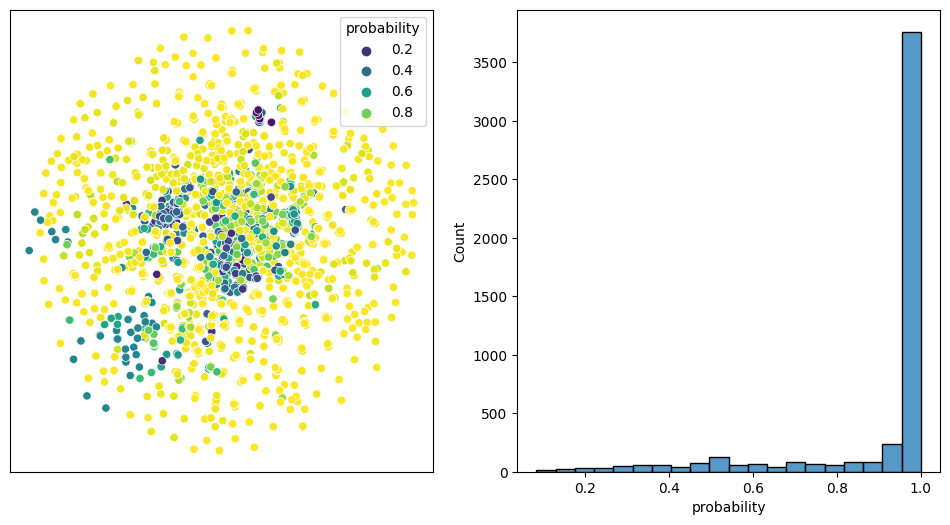

In [7]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')


plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our low model probabilities tend to be near each other, as if our model is having trouble with characters that are very similar. Which is probably not surprising.